In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Chargement des données
df = pd.read_csv("./../données/dataset_tfhe_execution_times5.csv")

In [13]:
def classer_operation(op):
    if "Tri" in op:
        return "tri"
    elif "Programme" in op:
        return "programme"
    else:
        return "elementaire"

df["groupe_operation"] = df["operation"].apply(classer_operation)

In [24]:
df_elementaire = df[df["groupe_operation"] == "elementaire"].copy()
#df_tri = df[df["groupe_operation"] == "tri"].copy()
#df_programme = df[df["groupe_operation"] == "programme"].copy()

In [25]:
# 5. Ajout d'une colonne de complexité

def complexite(op):
    if "Multiplication" in op or "Division" in op or "Tri" in op:
        return "complexe"
    elif "Addition" in op or "Soustraction" in op:
        return "moyenne"
    else:
        return "rapide"

df_elementaire["complexite_operation"] = df_elementaire["operation"].apply(complexite)
#df_tri["complexite_operation"] = df_tri["operation"].apply(complexite)
#df_programme["complexite_operation"] = df_programme["operation"].apply(complexite)

In [26]:
# Transformation log
df_elementaire["temps_log"] = np.log10(df_elementaire["temps_s"] + 1e-9)
#df_tri["temps_log"] = np.log10(df_tri["temps_s"] + 1e-9)
#df_programme["temps_log"] = np.log10(df_programme["temps_s"] + 1e-9)

In [27]:
# Fonction pour entraîner un modèle sur un sous-ensemble

def entrainer_modele(df_sous_ensemble, nom_complexite):
    df_sous_ensemble = df_sous_ensemble.copy()
    X_raw = df_sous_ensemble.drop(columns=[
        "temps_s", "temps_log", "echelle", "groupe_operation", "complexite_operation"])
    y = df_sous_ensemble["temps_log"]

    X = pd.get_dummies(X_raw, columns=["operation", "param_tfhe", "type_donnee"])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred_log = model.predict(X_test)
    y_pred_real = 10**y_pred_log - 1e-9
    y_test_real = 10**y_test - 1e-9

    print("Y_pred:", y_pred_real)
    print("Y_test:", y_test_real)

    print(f"\n--- Modèle '{nom_complexite}' ---")
    print("MAE:", mean_absolute_error(y_test_real, y_pred_real))
    print("R²:", r2_score(y_test_real, y_pred_real))
    print("RMSE:", np.sqrt(mean_squared_error(y_test_real, y_pred_real)))

    # Graphe prédiction vs réalité
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test_real, y=y_pred_real)
    plt.plot([min(y_test_real), max(y_test_real)], [min(y_test_real), max(y_test_real)], '--r')
    plt.xlabel("Temps réel (s)")
    plt.ylabel("Temps prédit (s)")
    plt.title(f"Prédiction vs Réalité - {nom_complexite}")
    plt.tight_layout()
    plt.show()


    importances = model.feature_importances_
    feature_names = X.columns

    plt.figure(figsize=(10, 8))
    plt.barh(feature_names, importances)
    plt.title(f"Importance des variables - {nom_complexite}")
    plt.xlabel("Score")
    plt.tight_layout()
    plt.show()

Y_pred: [1.60579130e-03 3.43817719e-03 3.29713781e-04 4.22529502e-05
 1.70382421e-05 1.90193610e+00 6.59322946e-03 1.01126466e+00
 2.18826001e-01 4.64476474e-01 4.22529502e-05 6.12962948e-02
 2.49165612e-01 1.59535953e-04 9.81843090e-01 1.59535953e-04
 2.49774636e+00 1.08109032e-03 5.56749436e-02 1.18818324e-01
 1.28346200e+00 2.49165612e-01 2.33313742e-03 5.19295425e-04
 6.75769023e-02 2.18826001e-01 3.78103794e-03 6.82291690e-02
 4.27701832e-06 1.19016556e-01 7.07807698e-06 7.34090877e-04
 1.43274678e-03 2.54428403e-05 1.28076946e+00 1.89275147e-01
 1.77008516e+00 9.27845996e-01 1.08109032e-03 1.72287397e-03
 2.46775323e+00 2.02424703e+00 1.36998108e-03 1.90193610e+00
 3.43817719e-03 7.90536771e-05 1.18818324e-01 9.27845996e-01
 2.33313742e-03 3.55081933e-01 3.74148117e-02 5.92034085e-02
 3.95144409e-01 2.15523274e+00 1.76369076e-05 9.65807248e-06
 4.78853827e+00 1.88558612e-01 7.23443498e-05 1.72287397e-03
 6.59540143e-02 2.89687480e-05 2.54428403e-05 4.81104138e-01
 4.45097491e-06 

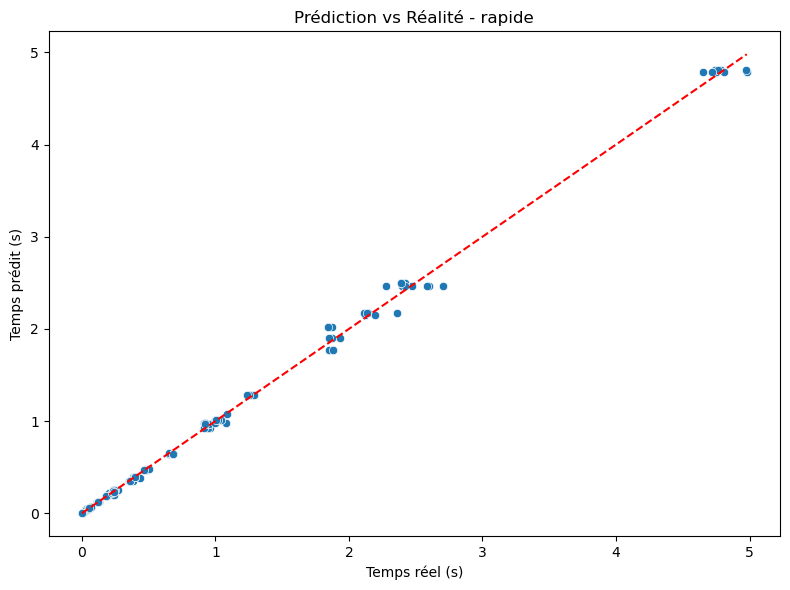

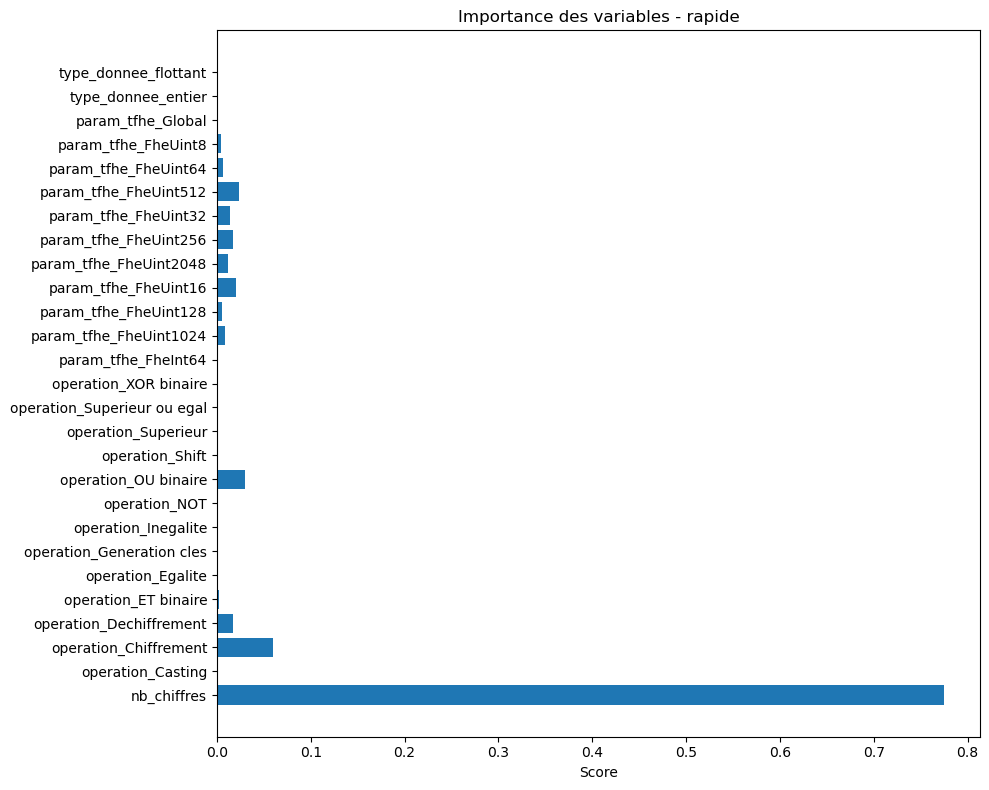

Y_pred: [ 0.11191795  0.12814761  8.3143123   0.84298027  0.40305829  4.13171457
  0.11191795  3.93021459  1.67044782  0.18298621  4.12297968  8.33780163
  4.13171457  0.16913136  8.34249751  0.8208436   0.40305829  0.19556789
  0.32548471  0.12814761  4.12297968  1.42646363  1.67044782  8.34249751
  8.33780163  0.12814761  0.12814761  0.8208436   8.33780163  0.32548471
  1.67044782  8.34249751  0.12814761 16.66012358  0.69084191  1.67044782
  1.42646363  3.93021459  0.38407535  4.13171457  4.12297968  0.18298621
  0.81443451  0.80132123  4.12297968  8.34249751  4.13171457  0.8208436
  0.19556789 16.66012358  0.84298027  0.40305829  4.12297968  0.84298027
 16.66012358  8.33780163  1.80488458  1.42646363]
Y_test: 73       0.093203
1725     0.120929
961      8.370794
1430     0.830109
1525     0.431134
1133     4.208223
1741     0.108306
591      4.208759
1334     1.635896
231      0.176435
1163     4.165533
942      8.353744
1124     4.263062
1643     0.169954
47       5.858142
1438    

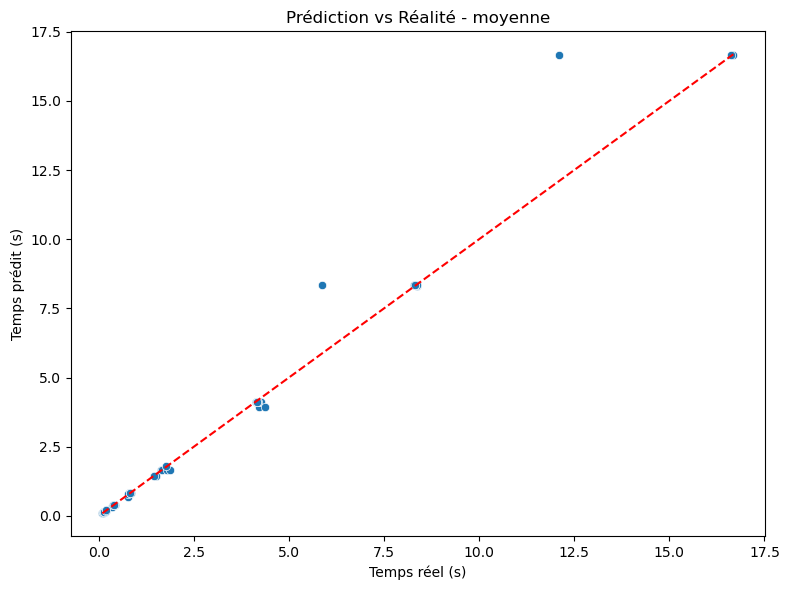

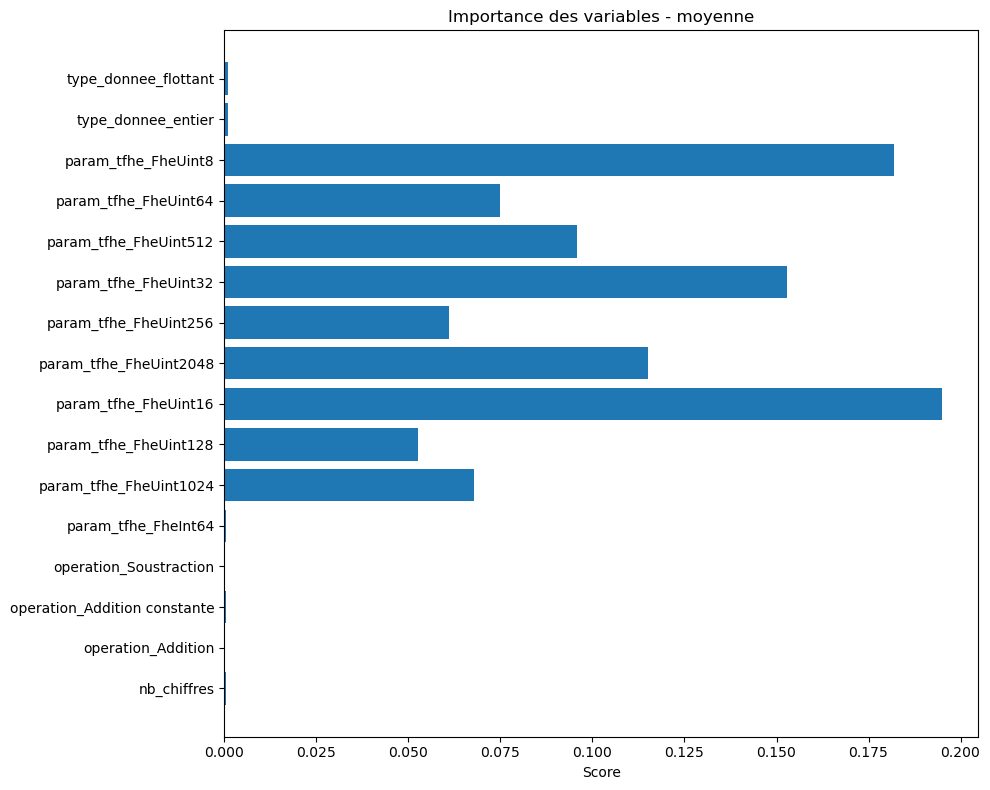

Y_pred: [2.08891998e+02 5.53424677e+01 1.37072805e+01 3.39561525e+01
 3.71129728e+00 5.53424677e+01 4.57743328e-01 4.02640433e+01
 8.39249518e+02 8.39249518e+02 2.60829344e-01 2.08891998e+02
 8.33360469e+00 8.36303254e-01 3.50017080e+00 8.39249518e+02
 3.71129728e+00 8.39249518e+02 2.60829344e-01 8.39249518e+02
 8.39249518e+02 5.53424677e+01 3.71129728e+00 2.21012795e-01
 1.37072805e+01 8.39249518e+02 3.71129728e+00 1.70723468e+01
 5.45963579e-02 3.39561525e+01 8.39249518e+02 8.33360469e+00
 5.45963579e-02 3.50017080e+00 2.08891998e+02 3.50017080e+00
 8.39249518e+02 3.50017080e+00 3.71129728e+00]
Y_test: 1178    209.902418
118      56.621668
1445     13.512203
866      41.180336
598       5.155198
1353     55.242295
505       0.448081
108      78.236159
972     842.150394
971     839.391525
1744      0.263427
129     194.023102
692      10.233830
75        1.296846
1544      3.495207
977     836.424275
599       5.144450
973     844.069432
1751      0.277249
979     836.259337
983     

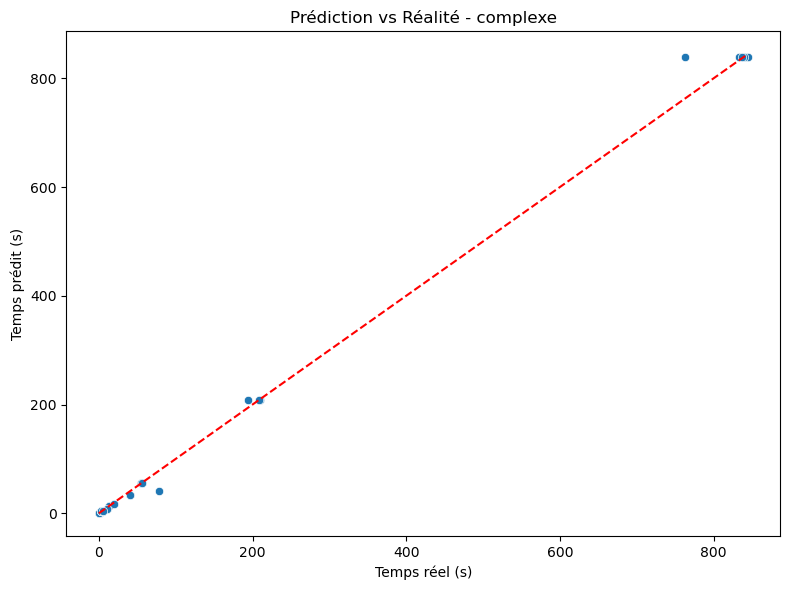

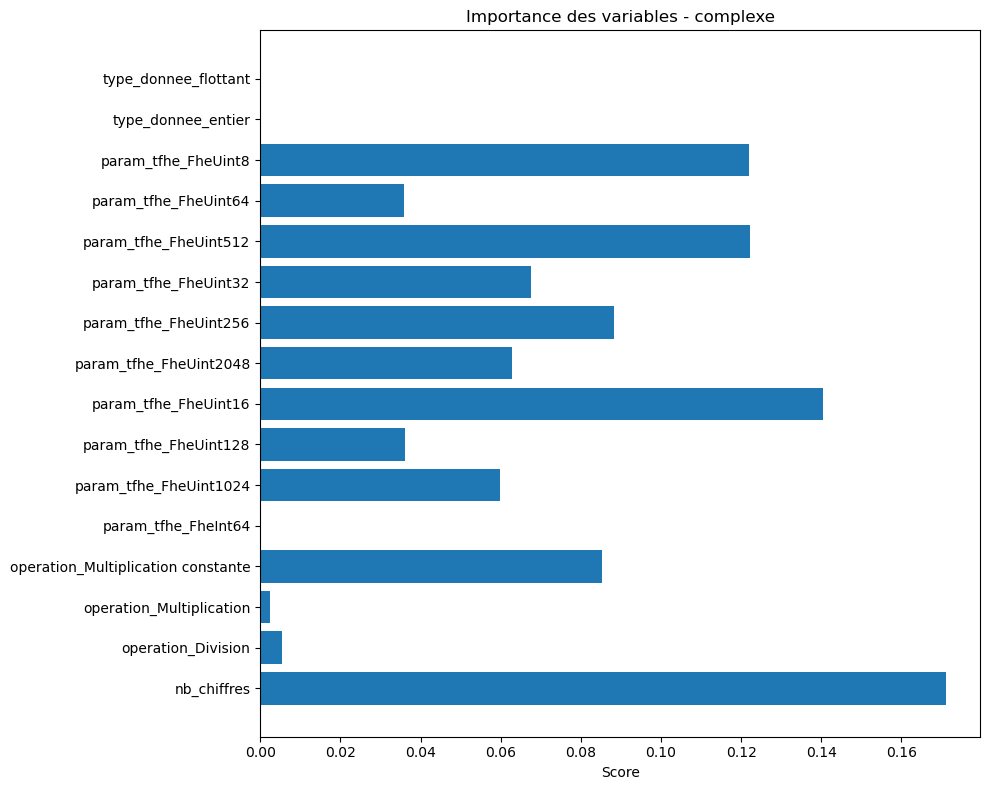

In [28]:
# Entraînement pour chaque complexité
for complexite in ["rapide", "moyenne", "complexe"]:
    subset = df_elementaire[df_elementaire["complexite_operation"] == complexite]
    #subset = df_tri[df_tri["complexite_operation"] == complexite]
    #subset = df_programme[df_programme["complexite_operation"] == complexite]
    if not subset.empty:
        entrainer_modele(subset, complexite)